# Analysis of software and data referencing in hep-lat, 2021

## Setup

### Imports

In [1]:
from collections import Counter
import pathlib

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import pandas as pd
import seaborn as sns

### Import data

In [2]:
survey = pd.read_csv('survey_2021.csv', true_values=['Y'], false_values=['N'])

### Add extra derived fields to make plotting easier

In [3]:
survey['Is crosslist'] = survey['Primary category'].where(survey['Primary category'] == 'hep-lat', 'Crosslist')

def boolify_yn(survey, fieldname):
    survey[f'{fieldname}?'] = survey[fieldname].str.startswith('Y')

boolify_yn(survey, 'Generates field configurations')
boolify_yn(survey, 'Performs measurements')
boolify_yn(survey, 'Presents new numerical results')
boolify_yn(survey, 'Uses existing configurations')
boolify_yn(survey, 'Reanalyses other existing data')
boolify_yn(survey, 'UK authors')
boolify_yn(survey, 'Acknowledges an HPC centre')
survey['Author Origin'] = survey['UK authors?'].map(lambda uk : 'UK author(s)' if uk else 'All non-UK')


def boolify_softwareref(survey, fieldname):
    survey[f'{fieldname}?'] = ~survey[fieldname].isin([np.nan, 'No'])

boolify_softwareref(survey, 'Specifies software used for analysis')
boolify_softwareref(survey, 'Specifies software used for configuration generation')
boolify_softwareref(survey, 'Specifies software used for measurement')
boolify_softwareref(survey, 'Lattice data grid acknowledged')

survey['Specifies any software?'] = (
    survey['Specifies software used for analysis?']
    | survey['Specifies software used for configuration generation?']
    | survey['Specifies software used for measurement?']
)

survey['Data published'] = 'None'
survey.loc[survey['Data available on request?'].str.startswith('Y'), 'Data published'] = 'Data available on request'
survey.loc[survey['Publishes data'].str.startswith('Y'), 'Data published'] = 'Some or all data published'

survey['Analysis published'] = 'No'
survey.loc[survey['Publishes parts of analysis'].str.startswith('Y'), 'Analysis published'] = 'Partial'
survey.loc[survey['Publishes full analysis'].str.startswith('Y'), 'Analysis published'] = 'Full'

### Subset data

In [4]:
lattice_all = survey[survey['Primary category'] == 'hep-lat']
numerical = survey[survey['Presents new numerical results?']]

lattice_numerical = lattice_all[lattice_all['Presents new numerical results?']]
lattice_papers = lattice_all[~lattice_all['Is proceedings']]
lattice_numerical_papers = lattice_papers[lattice_papers['Presents new numerical results'].str.startswith('Y')]
lattice_generators = lattice_all[lattice_all['Generates field configurations?']]
lattice_measurers = lattice_all[lattice_all['Performs measurements?']]

nonlattice_all = survey[survey['Primary category'] != 'hep-lat']
nonlattice_numerical = nonlattice_all[nonlattice_all['Presents new numerical results?']]

### Utility functions

In [5]:
def get_codes(series):
    codes = []
    modified_count = 0

    for entry in series:
        if isinstance(entry, str):
            entry_codes = entry.split(', ')
            for code in entry_codes:
                if code.endswith(' (modified)'):
                    codes.append(code[:-11])
                    modified_count += 1
                else:
                    codes.append(code)
                    
    return codes, modified_count


def tfplot(fieldname, annotate=True):
    g = sns.catplot(
        x=fieldname,
        kind='count',
        data=lattice_numerical,
        col='Author Origin'
    ).set_titles('{col_name}')

    max_count = max(Counter(lattice_numerical[fieldname]).values())
    count = len(lattice_numerical)

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(count))
        ax.yaxis.set_ticks(np.arange(0, ((max_count * 10) // count + 1) / 10 * count, count / 10))

    if annotate:
        annotate_axes(g.axes[0][1], len(lattice_numerical))

    return g


def annotate_axes(axes, counts, offset=0):
    if not isinstance(counts, list):
        axes = [[axes]]
        counts = [counts]

    for ax, count in zip(axes[0], counts):
        ax.annotate(f'Out of {count}', (1 - offset, 0.95 - offset), xycoords='axes fraction', ha='right')
        

def annotate_axes_uk(grid, df):
    annotate_axes(grid.axes, 
              [sum(df['Author Origin'] == 'All non-UK'),
               sum(df['Author Origin'] == 'UK author(s)')])

## Plotting styles

In [6]:
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Futura'
plt.rcParams['font.size'] = 14

def savefig(filename):
    plot_dir = pathlib.Path('plots')
    ext = 'svg'
    plot_dir.mkdir(exist_ok=True)
    plt.savefig(plot_dir / f'{filename}.{ext}', transparent=True)

## Breaking down the papers

### How many papers presented numerical data?

I.e. wasn't e.g. a review paper or a pure theory paper

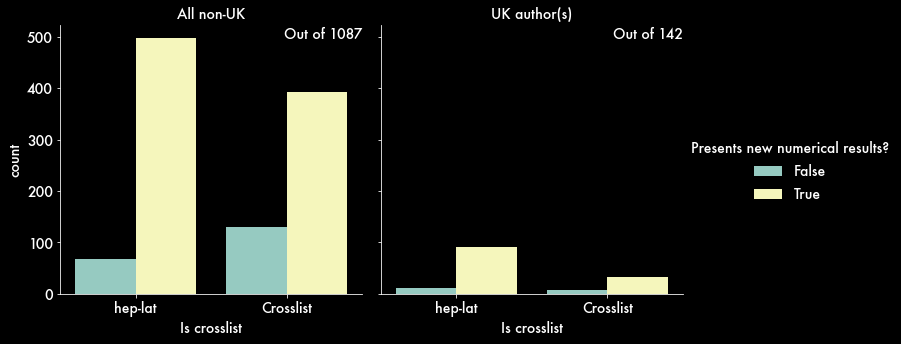

In [7]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Presents new numerical results?',
    kind='count',
    data=survey,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')

annotate_axes_uk(grid, survey)

savefig('all_numerical')

From here on we'll consider papers that present numerical results.

## Comparing hep-lat with cross-lists

### How many papers specify any of the software they used?

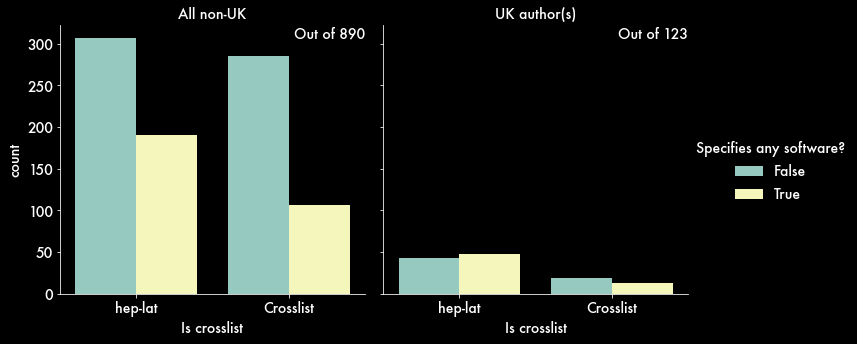

In [8]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Specifies any software?',
    kind='count',
    data=numerical,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')

annotate_axes_uk(grid, numerical)

savefig('specifies_any_software')

While hep-lat cites software more frequently than cross-lists, more than half of papers still do not cite or otherwise acknowledge any software. Papers including UK authors tend to be more consciencious about specifying software than non-UK in both cases.

### How do papers specify the software that they use?

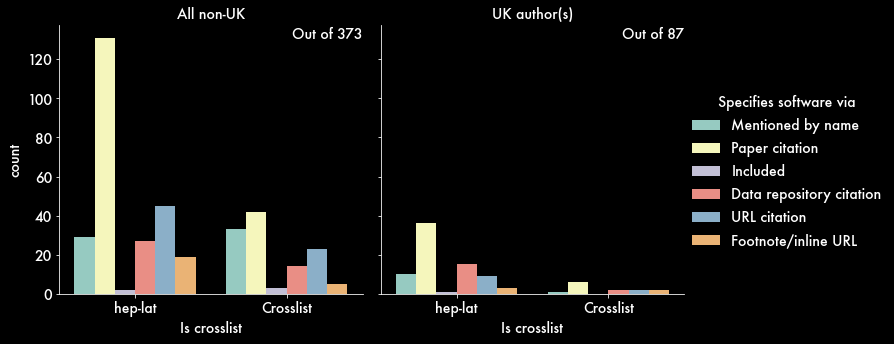

In [9]:
numerical_allsoftware = numerical.melt(
    id_vars=['Is crosslist', 'Author Origin'],
    value_vars=['Specifies software used for analysis',
                'Specifies software used for configuration generation',
                'Specifies software used for measurement']
)
numerical_allsoftwarecites = (
    numerical_allsoftware[~numerical_allsoftware['value'].isin([np.nan, 'No'])]
    .rename(columns={'value': 'Specifies software via'})
)

grid = sns.catplot(
    x='Is crosslist',
    hue='Specifies software via',
    kind='count',
    data=numerical_allsoftwarecites,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')

annotate_axes_uk(grid, numerical_allsoftwarecites)

savefig('how_specifies_any_software')

Both in the UK and elsewhere, hep-lat publications are much more likely than crosslists to cite papers describing software rather than directly citing software as its own research output.

### And where does this software live?

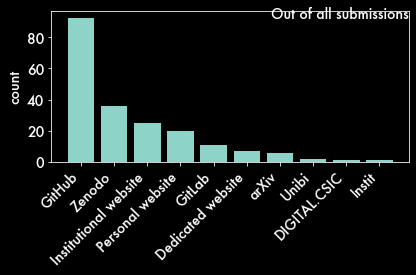

In [10]:
cfg_repos, _ = get_codes(survey['Repository/hosting service for configuration generation code'])
meas_repos, _ = get_codes(survey['Repository/hosting service for measurement code'])
anal_repos, _ = get_codes(survey['Repository/hosting service for analysis code'])
                
plt.bar(*zip(*list(Counter(cfg_repos + meas_repos + anal_repos).most_common())[:10]))
plt.ylabel('count')
plt.xticks(rotation=45, ha='right')

annotate_axes(plt.gca(), 'all submissions', offset=0.02)

plt.tight_layout(rect=(0, 0, 1, 1))
savefig('all_software_locations')
plt.show()

GitHub is the most popular, but repositories like Zenodo and Unibi also feature.

## Configuration generation

Focusing now on numerical hep-lat papers.

### How many papers generate their own field configurations?

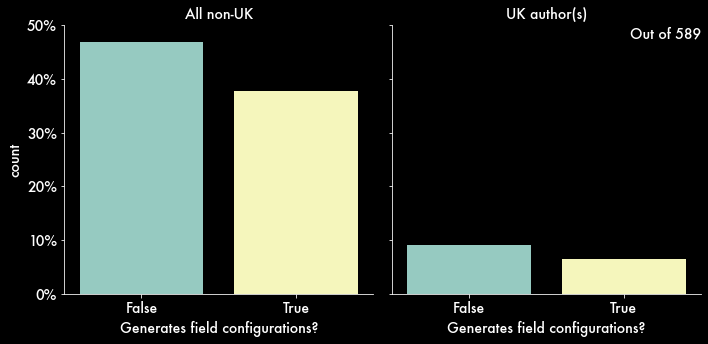

In [11]:
tfplot('Generates field configurations?')
savefig('generates_configurations')

The majority of papers do not generate new gauge configurations.

Focusing on those that do,

### How many specify what software was used?

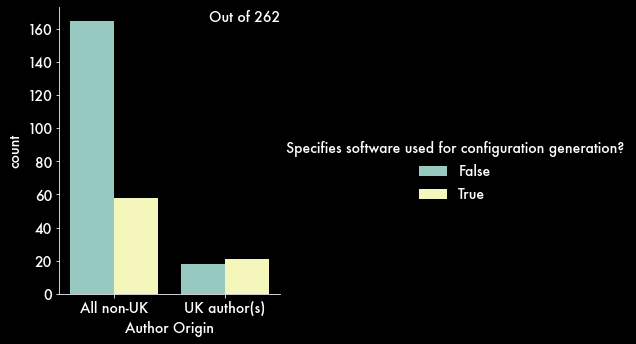

In [12]:
grid = sns.catplot(
    x='Author Origin',
    hue='Specifies software used for configuration generation?',
    kind='count',
    data=lattice_generators,
).set_titles('{col_name}')
annotate_axes(grid.axes, [len(lattice_generators)])
savefig('specifies_configuration_generation_software')

### Top ten codes used to generate gauge configurations

11 of these indicate unreleased modifications


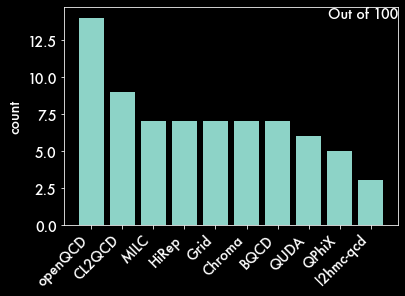

In [13]:
mc_codes, mc_modified = get_codes(survey['Software used for configuration generation'])
                
plt.bar(*zip(*list(Counter(mc_codes).most_common())[:10]))
plt.ylabel('count')
plt.xticks(rotation=45, ha='right')
annotate_axes(plt.gca(), survey['Specifies software used for configuration generation?'].sum(), offset=0.02)
print(mc_modified, 'of these indicate unreleased modifications')
plt.tight_layout(rect=(0, 0, 1, 1))
savefig('configuration_generation_software')

In fact the number of unreleased modifications will be higher - e.g. Chroma and Grid rely on additional code that groups do not release.

## Configuration origins

More than half of papers aren't generation configurations—where are they getting them?

### How many papers use pre-existing field configurations?

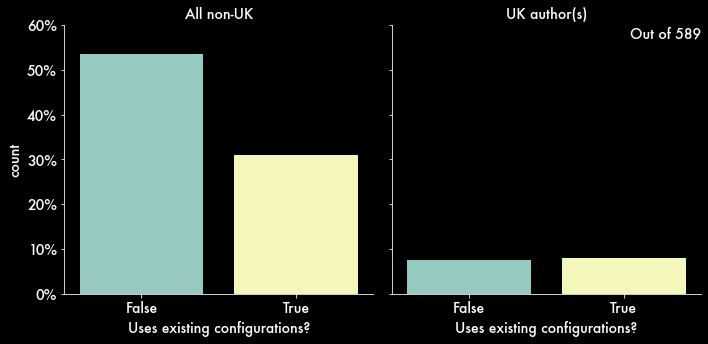

In [14]:
tfplot('Uses existing configurations?')
savefig('uses_existing_configurations')

Papers with UK authors are somewhat more likely to use existing configurations than entirely non-UK works.

## How do papers specify the ensembles they use?

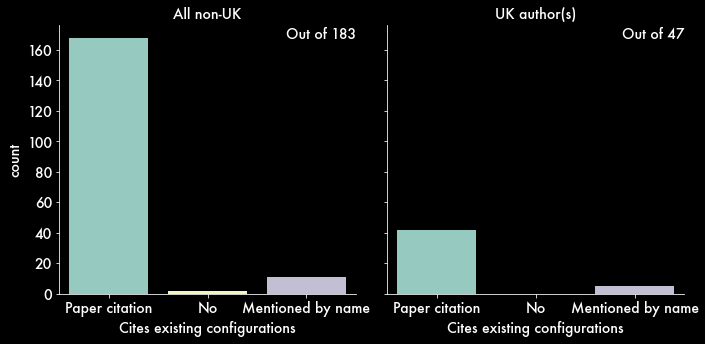

In [15]:
grid = sns.catplot(
    x='Cites existing configurations',
    kind='count',
    data=lattice_numerical[lattice_numerical['Uses existing configurations?']],
    col='Author Origin'
).set_titles('{col_name}')
annotate_axes_uk(grid, lattice_numerical[lattice_numerical['Uses existing configurations?']])
savefig('how_specify_ensembles')

The vast majority reference a paper. One doesn't acknowledge or reference the original ensemble at all, instead citing a previous work of the authors that used the ensemble.

### Is a lattice data grid cited?

Data grids are a FAIR way of sharing configuration data—how recognised are they?

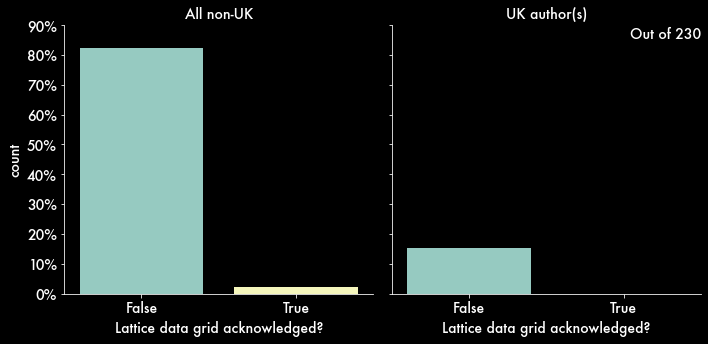

In [16]:
grid = tfplot('Lattice data grid acknowledged?', annotate=False)
annotate_axes(grid.axes[0][1], lattice_numerical['Uses existing configurations?'].sum())
savefig('acknowledges_data_grid')

If LDGs are used, they are not commonly acknowledged; not at all by UK authors. Which ones are referred to?

### Which lattice data grids are acknowledged?

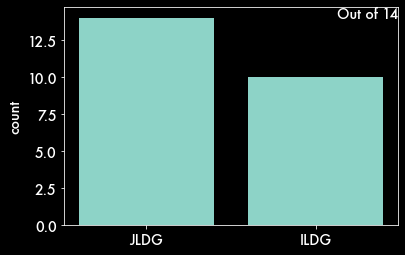

In [17]:
grids, _ = get_codes(survey['Lattice data grid acknowledged'])
                
plt.bar(*zip(*list(Counter(grids).most_common())[:10]))
plt.ylabel('count')
annotate_axes(plt.gca(), lattice_numerical['Lattice data grid acknowledged?'].sum(), offset=0.02)
plt.tight_layout(rect=(0, 0, 1, 1))
savefig('which_data_grids')
plt.show()

Not shown here is that all acknowledgements to ILDG also acknowledge JLDG. Either JLDG is the only LDG in common use, or its users are particularly consciencious about acknowledgement.

### Which collaborations are generating the configurations being used?

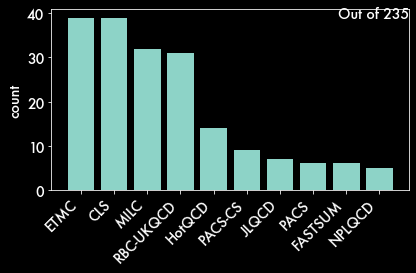

In [18]:
collaborations, _ = get_codes(survey['Configurations generated by'])
                
plt.bar(*zip(*list(Counter(collaborations).most_common())[:10]))
plt.xticks(rotation=45, ha='right')
plt.ylabel('count')
annotate_axes(plt.gca(), survey['Uses existing configurations?'].sum(), offset=0.02)
plt.tight_layout(rect=(0, 0, 1, 1))
savefig('used_configuration_generating_collaborations')
plt.show()

## Measurements

### What proportion of numerical papers in hep-lat perform measurements on field configurations?

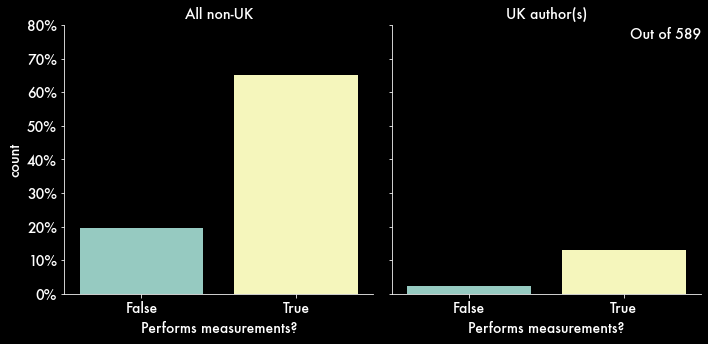

In [19]:
tfplot('Performs measurements?')
savefig('performs_measurements')

Around 80%—the remaining 20% include things like tensor networks and quantum simulations.

### And how many of these specify what software they use?

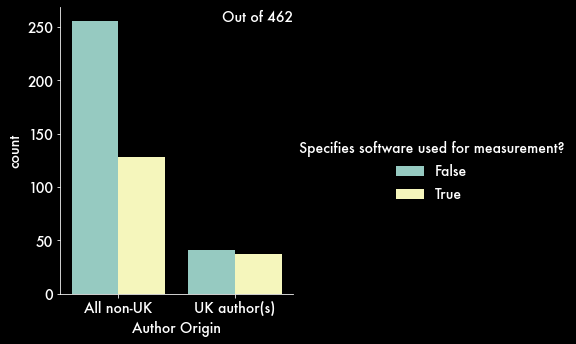

In [20]:
grid = sns.catplot(
    x='Author Origin',
    hue='Specifies software used for measurement?',
    kind='count',
    data=lattice_measurers
).set_titles('{col_name}')
annotate_axes(grid.axes, [len(lattice_measurers)])
savefig('specifies_measurement_software')

### What codes are used for measurement?

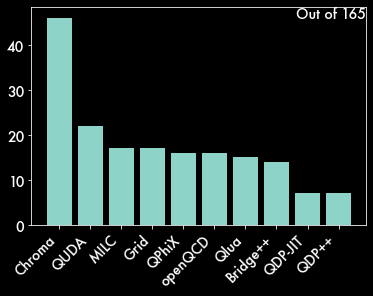

27 of these indicate unreleased modifications


In [21]:
meas_codes, meas_modified = get_codes(survey['Software used for measurements'])
                
plt.bar(*zip(*list(Counter(meas_codes).most_common())[:10]))
plt.xticks(rotation=45, ha='right')
annotate_axes(plt.gca(), lattice_measurers['Specifies software used for measurement?'].sum(), offset=0.02)
plt.tight_layout(rect=(0, 0, 1, 1))
savefig('measurement_software')
plt.show()

print(meas_modified, 'of these indicate unreleased modifications')

As before, the real number of unreleased modifications will be higher.

## Other data sources

Configurations aren't the only data that research can use as input.

### What proportion of papers mention a source of data other than field configurations?

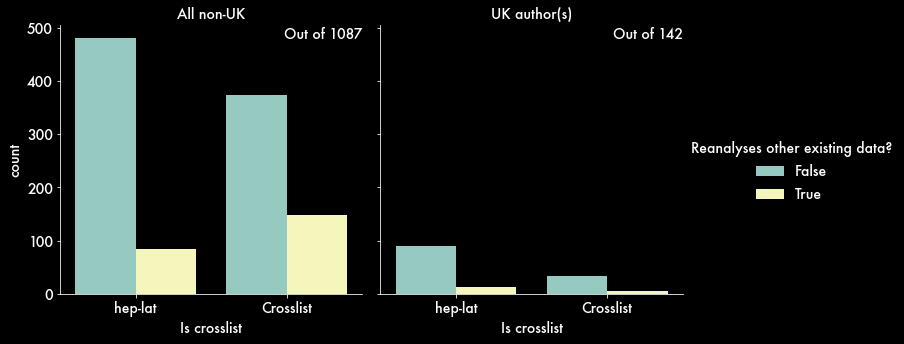

In [22]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Reanalyses other existing data?',
    kind='count',
    data=survey,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')
annotate_axes_uk(grid, survey)
savefig('use_other_data')

Crosslists use proportionally more non-configuration data than hep-lat papers. Anecdotally, this is likely because of the high number of phenomenological and adjacent papers that use final values from e.g. lattice publications as their inputs.

### How are non-configuration data acknowledged?

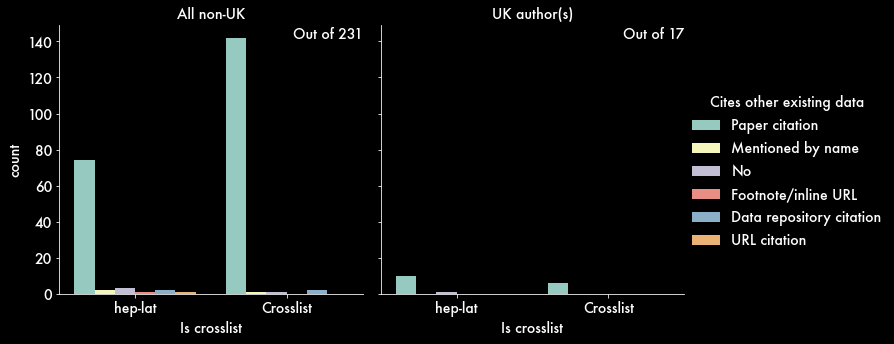

In [23]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Cites other existing data',
    kind='count',
    data=numerical,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')
annotate_axes_uk(grid, numerical[numerical['Reanalyses other existing data?']])
savefig('how_acknowledges_other_data')

The vast majority of data are cited via publication. This doesn't necessarily mean that data are always being transcribed from PDFs to be re-used in these cases: anecdotally, a noticeable number of papers include acknowledgements to individual members of other collaborations for providing (presumably raw) data. However, this is not the majority, and even in such cases it is not clear what form the data took, or how it could be available to other researchers.

## Publishing data

From consuming data to making it available.

### Do papers producing numerical results make their data available?

That is, are data provided in a form other than the numbers, plots, or tables presented in the LaTeX/PDF, suitable for others to make use of directly within their own code?

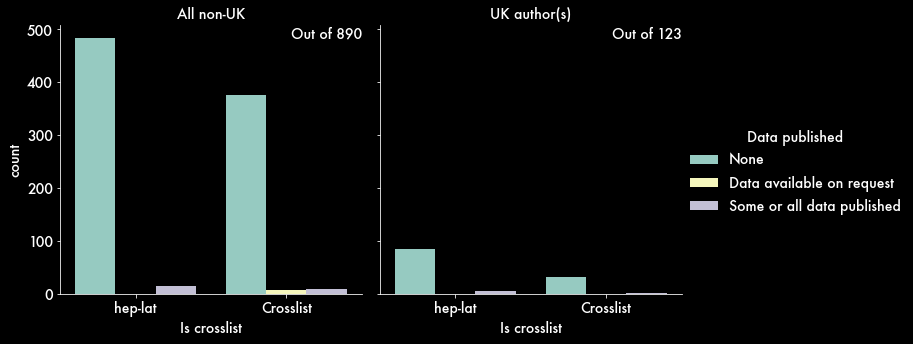

In [24]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Data published',
    kind='count',
    data=numerical,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin',
).set_titles('{col_name}')
annotate_axes_uk(grid, numerical)
savefig('publish_any_data')

Largely, no. However, the trend of using "data are available on request" as a get-out clause has not caught on in lattice.

### Where are data published?

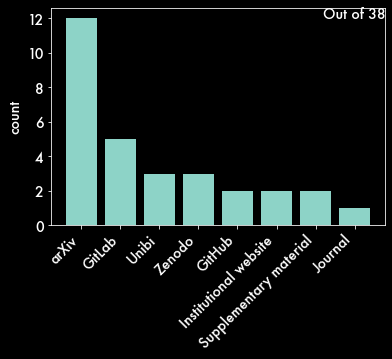

In [25]:
data_repositories, _ = get_codes(survey['Repository used for data'])
                
plt.bar(*zip(*list(Counter(data_repositories).most_common())[:10]))
plt.xticks(rotation=45, ha='right')
plt.ylabel('count')
annotate_axes(plt.gca(), (numerical['Data published'] != 'None').sum(), offset=0.02)
plt.tight_layout(rect=(0, 0, 1, 1))
savefig('used_data_repositories')
plt.show()

GitLab overtakes GitHub for data storage, and outperforms dedicated data repositories such as Zenodo. However, all are beaten by the arXiv itself, either as extra files hidden in the source bundle, or as ancillary files that are linked from the abstract page.

## Data analysis

Now data are produced (and sometimes published), how are they analysed to give the final results included in publications?

### Do publications specify what software has been used for analysis of data?

This is what many disciplines would call the "reproducibility question"—when data are collected experimentally, then this may be the only computational step.

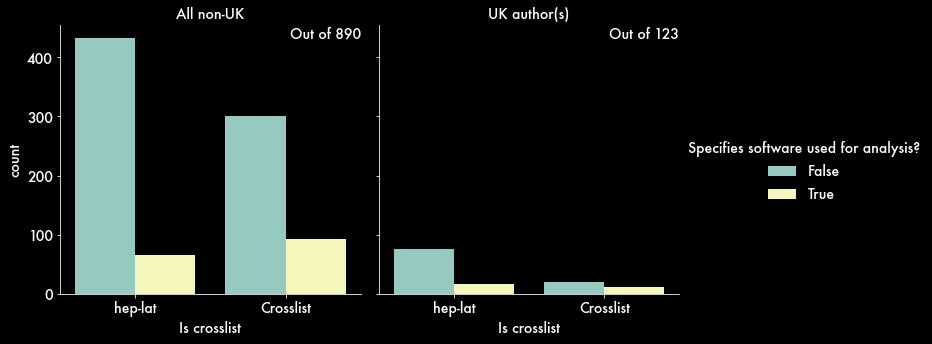

In [26]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Specifies software used for analysis?',
    kind='count',
    data=numerical,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')
annotate_axes_uk(grid, numerical)
savefig('specifies_analysis_software')

Caveat: hep-lat and crosslists aren't necessarily precisely comparable here, as lattice papers capture software for specific parts of the work, whereas any software used at all in non-lattice work will be captured. However, the low proportion specifying any of the software used for analysis is itself striking!

### What software is acknowledged for data analysis?

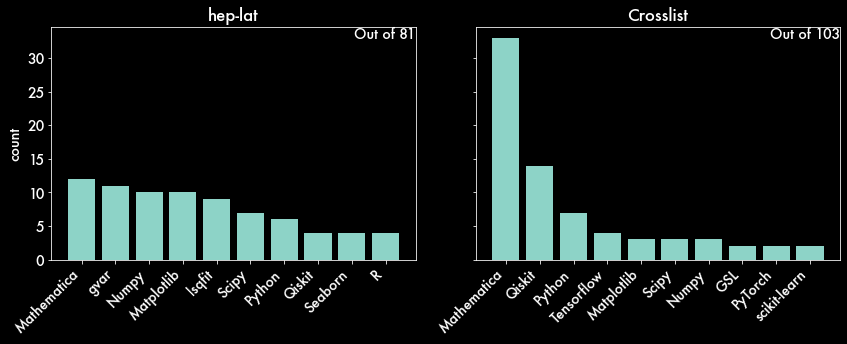

In [27]:
lattice_anal_codes, _ = get_codes(lattice_numerical['Software used for analysis'])
nonlattice_anal_codes, _ = get_codes(nonlattice_numerical['Software used for analysis'])

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

axes[0].set_title('hep-lat')
axes[0].bar(*zip(*list(Counter(lattice_anal_codes).most_common())[:10]))
axes[0].set_ylabel('count')
axes[0].set_ylabel('count')

axes[1].set_title('Crosslist')
axes[1].bar(*zip(*list(Counter(nonlattice_anal_codes).most_common())[:10]))

for ax in axes:
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_rotation(45)
        ticklabel.set_ha('right')
        
fig.tight_layout()
annotate_axes([axes],
              [lattice_numerical['Software used for analysis'].count(),
               nonlattice_numerical['Software used for analysis'].count()],              offset=0.02)
savefig('acknowledged_analysis_software')
plt.show()

Python and Mathematica are the languages of choice in both cases. However, it's not clear if that's because Mathematica and Python users are particularly consciencious about acknowledging their software, or if it represents a wider preference for these languages.

### How is data analysis software cited?

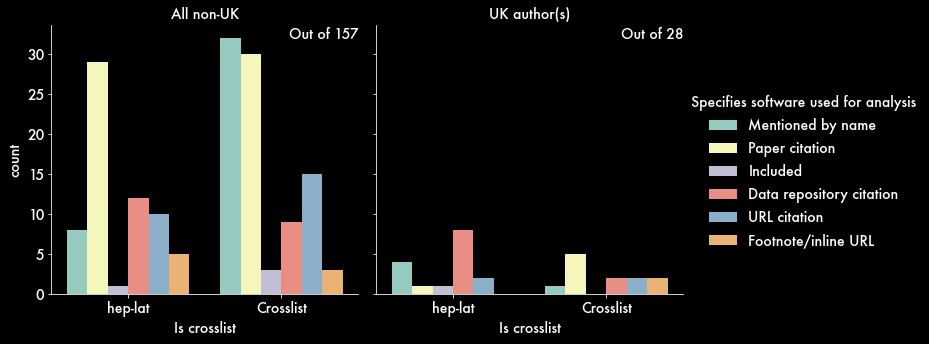

In [28]:
numerical_analsoftwarecites = numerical[~numerical['Specifies software used for analysis'].isin([np.nan, 'No'])]

grid = sns.catplot(
    x='Is crosslist',
    hue='Specifies software used for analysis',
    kind='count',
    data=numerical_analsoftwarecites,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')
annotate_axes_uk(grid, numerical_analsoftwarecites)
savefig('how_analysis_software_cited')

hep-lat is less likely to name-drop software for data analysis without a citation, and in the UK is also more likely to cite a data repository.

### How many numerical papers acknowledge HPC resources?

Acknowledging HPC resources is similarly challenging to acknowledging software resources. In principle, both are requested as a condition of use, too.

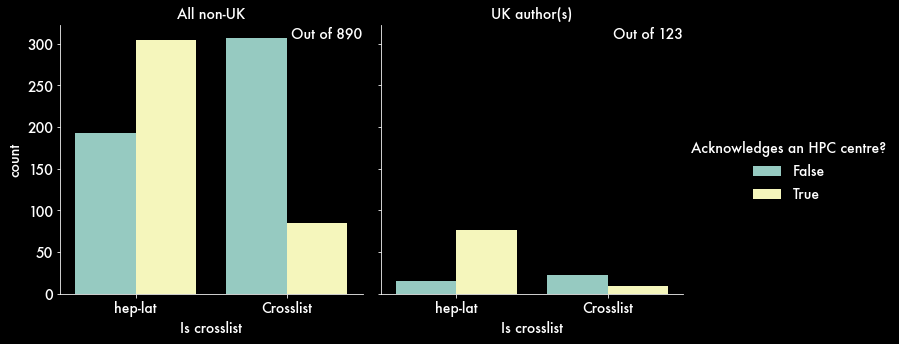

In [29]:
grid = sns.catplot(
    x='Is crosslist',
    hue='Acknowledges an HPC centre?',
    kind='count',
    data=numerical,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')
annotate_axes_uk(grid, numerical)
savefig('acknowledges_compute_resources')

The majority of numerical hep-lat papers (and the overwhelming majority in the UK) acknowledge computing resources. How can that be extended to software resources?

### Do papers acknowledge DiRAC or Supercomputing Wales?

(This question is quite UK-specific.)

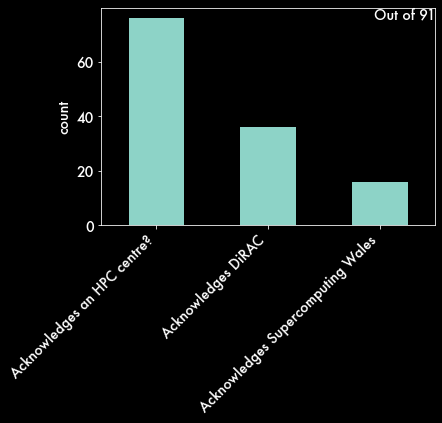

In [30]:
lattice_numerical[lattice_numerical['UK authors?']].loc[
    :, ['Acknowledges an HPC centre?', 'Acknowledges DiRAC', 'Acknowledges Supercomputing Wales']
].sum().plot.bar()
plt.xticks(rotation=45, ha='right')
plt.ylabel('count')
annotate_axes(plt.gca(), lattice_numerical['UK authors?'].sum(), offset=0.02)
plt.tight_layout(rect=(0, 0, 1, 1))
savefig('dirac_scw')

Almost half as many paper acknowledge one local/regional HPC centre as acknowledge the national HPC service; demonstrating the need for an ecosystem of services at various degrees of power and locality.

### How many numerical papers publish their analysis workflow?

Specifying the software used for the analysis is only part of the story—all of the top software above are languages and libraries that must be incorporated into code to give answers. 

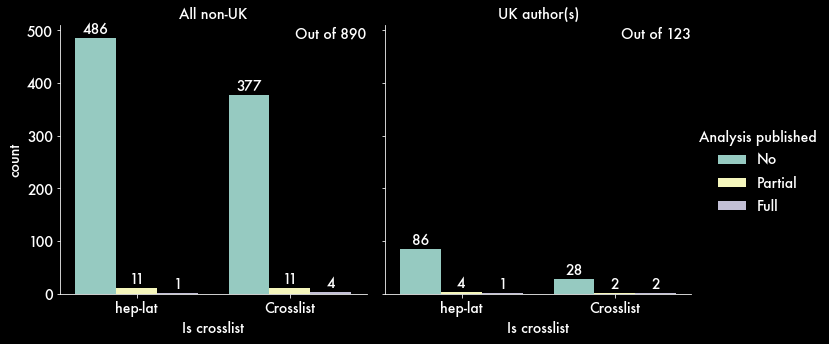

In [31]:
g = sns.catplot(
    x='Is crosslist',
    hue='Analysis published',
    kind='count',
    data=numerical,
    order=['hep-lat', 'Crosslist'],
    col='Author Origin'
).set_titles('{col_name}')

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

annotate_axes_uk(g, numerical)
savefig('publish_analysis_workflow')

The number publishing the full analysis is too small to do statistics on, and the number publishing even part of the analysis isn't much better. The vast majority of publications rely solely on the text description of their analysis to convey what was done.